In [257]:
import csv
import matplotlib.pyplot as plt
from operator import itemgetter, attrgetter
import pandas as pd
import seaborn as sn
import math
import scipy.spatial as spatial
import scipy.stats as stats
import numpy as np
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

In [259]:
#Constants
INTERESTING_PATHS = [
    '../scripts/allModels/',
    '../scripts-clones/highBranchSmall_2/',
    '../scripts-clones/highBranchMidActions/',
    '../scripts-clones/randomRun/',
    '../scripts-clones/smallBranch/',
    '../scripts/MECrelated/',
]
PATH_TO_CSV_FOLDER = INTERESTING_PATHS[1]
print("Chosen Path: "+PATH_TO_CSV_FOLDER)

Chosen Path: ../scripts-clones/highBranchSmall_2/


## Load Data

In [261]:
property_meta_keys = ["Model"]

property_keys = [
    "NumStates",
    "NumActions",
    "NumTargets",
    "NumSinks",
    "NumUnknown",
    "NumMaxActions",
    "NumMaxTransitions",
    "SmallestTransProb",
    "NumProbActions",
    "NumMECs",
    "BiggestMEC",
    "SmallestMEC",
    "AvgMEC",
    "MedianMEC",
    "NumSCCs"
]

analysis_keys = property_meta_keys + property_keys

unknown_threshold = 5
def should_remove_model(row_to_include, analysis_keys, filter_dict):
    if (row_to_include["NumStates"] == " "):
        filter_dict["Timeout"] +=1
        return True
    elif (("NumUnknown" in analysis_keys) and int(row_to_include["NumUnknown"]) <= unknown_threshold):
        filter_dict["Unknown<=%d" % unknown_threshold] +=1
        return True
    return False

def normalization(row, analysis_keys):
    if ("NumStates" in analysis_keys):
        for value_to_normalize in [
            "NumTargets",
            "NumSinks",
            "NumUnknown",
        ]:
            if (value_to_normalize in analysis_keys):
                row[value_to_normalize] = float(row[value_to_normalize]) / float(row["NumStates"]) 

filter_dict = dict()
filter_dict["Unknown<=%d" % unknown_threshold] = 0 #Not an interesting model
filter_dict["Timeout"] = 0
table_properties = []
total_rows = 0
with open(PATH_TO_CSV_FOLDER+'analysis.csv', newline='\n') as propertiesFile:
        reader = csv.DictReader(propertiesFile)
        for row in reader:
            total_rows += 1
            row_to_include = {k:row[k] for k in analysis_keys if k in row}

            #Filtering
            if (should_remove_model(row_to_include, analysis_keys, filter_dict)):
                continue

            #Normalizations
            normalization(row_to_include, analysis_keys)

            table_properties.append(row_to_include)

print("With filtering there are %d/%d models left to check from" % (len(table_properties), total_rows))
print("The rest was filtered because of following reasons: ")
print(filter_dict)

With filtering there are 134/225 models left to check from
The rest was filtered because of following reasons: 
{'Unknown<=5': 91, 'Timeout': 0}


In [267]:
metaKeys = ["Model", "#States"]

all_config_keys = [
    #"BVI_1",
    "BVI_100",
    #"GBVI_1",
    #"GBVI_100",
    #"GSVI_1",
    #"GSVI_100",
    #"GVI",
    #"OVI_1",
    #"OVI_100",
    "OVI_100_opt",
    "OVI_1_opt",
    #"SVI_1",
    #"SVI_100",
    "TBVI_1",
    #"TBVI_100",
    #"TGBVI_1",
    "TGBVI_100",
    #"TGSVI_1",
    #"TGSVI_100",
    #"TGVI",
    "TOVI_1",
    #"TOVI_100",
    "TOVI_100_opt",
    "TOVI_1_opt",
    #"TSVI_1",
    #"TSVI_100",
    #"TVI",
    #"VI",
    #"WP"
]

reduced_config_keys = [
    #"BVI_1",
    "BVI_100",
    #"GBVI_1",
    "GBVI_100",
    #"GSVI_100",
    "OVI_1",
    #"OVI_100",
    "OVI_1_opt",
    "SVI_100",
    #"TBVI_1",
    "TBVI_100",
    #"TGBVI_100",
    "TGSVI_100",
    #"TOVI_100",
    "TOVI_1_opt",
    #"TSVI_100",
    #"VI"
]

config_keys = reduced_config_keys

relevantKeys = metaKeys + config_keys
relevantKeys

['Model',
 '#States',
 'BVI_100',
 'GBVI_100',
 'OVI_1',
 'OVI_1_opt',
 'SVI_100',
 'TBVI_100',
 'TGSVI_100',
 'TOVI_1_opt']

#### Load Config Data

In [275]:
#Filtering Options

def should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved):
    #return False
    return at_least_one_has_not_solved
    #return not at_least_one_has_solved

In [276]:
def modelIncludedInProperties(model_name, table_properties):
    for row in table_properties:
        if row["Model"] == model_name:
            return True
    return False

In [277]:
table_times = []
excluded_times = []
print("PATH: ",PATH_TO_CSV_FOLDER+'times.csv')

conf_filter_dict = dict()
conf_filter_dict["NooneHasSolved"] = 0

with open(PATH_TO_CSV_FOLDER+'times.csv', newline='\n') as timesFile:
    reader = csv.DictReader(timesFile)
    for row in reader:
        parsed_row = {k:row[k] for k in relevantKeys if k in row}

        # Filtering
        if not modelIncludedInProperties(parsed_row["Model"], table_properties):
            continue
        if parsed_row["#States"] == '':
            #parsed_row["#States"] = 2074
            pass
        at_least_one_has_solved = False
        at_least_one_has_not_solved = False
        for config_key in config_keys:
            if (parsed_row[config_key] != "" and parsed_row[config_key] != " "):
                at_least_one_has_solved = True
                #print(parsed_row)
            else:
                at_least_one_has_not_solved = True


        if (should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved)):
            conf_filter_dict["NooneHasSolved"]+=1
            excluded_times.append(parsed_row)
        else:
            table_times.append(parsed_row)
print("After filtering, %d models are left in total" % len(table_times))
print("The not included confs are due to the following reasons: ")
print(conf_filter_dict)

PATH:  ../scripts-clones/highBranchSmall_2/times.csv
After filtering, 12 models are left in total
The not included confs are due to the following reasons: 
{'NooneHasSolved': 122}


In [278]:
table_iters = []
excluded_iters = []
print("PATH: ",PATH_TO_CSV_FOLDER+'iters.csv')

conf_filter_dict = dict()
conf_filter_dict["NooneHasSolved"] = 0

with open(PATH_TO_CSV_FOLDER+'iters.csv', newline='\n') as iters:
    reader = csv.DictReader(iters)
    for row in reader:
        parsed_row = {k:row[k] for k in relevantKeys if k in row}

        # Filtering
        if not modelIncludedInProperties(parsed_row["Model"], table_properties):
            continue
        if parsed_row["#States"] == '':
            #parsed_row["#States"] = 2074
            pass
        at_least_one_has_solved = False
        at_least_one_has_not_solved = False
        for config_key in config_keys:
            if (parsed_row[config_key] != "" and parsed_row[config_key] != " "):
                at_least_one_has_solved = True
            else:
                at_least_one_has_not_solved = True


        if (should_remove_model_conf(at_least_one_has_solved, at_least_one_has_not_solved)):
            conf_filter_dict["NooneHasSolved"]+=1
            excluded_iters.append(parsed_row)
        else:
            table_iters.append(parsed_row)
print("After filtering, %d models are left in total" % len(table_iters))
print("The not included confs are due to the following reasons: ")
print(conf_filter_dict)

PATH:  ../scripts-clones/highBranchSmall_2/iters.csv
After filtering, 12 models are left in total
The not included confs are due to the following reasons: 
{'NooneHasSolved': 122}


In [279]:
#Test Read Filed
for row in table_times:
    #print(row)
    pass

for row in table_properties:
    pass

### Unify Data

In [280]:
table_times = sorted(table_times, key=lambda row: int(row['#States']))
table_properties = sorted(table_properties, key=lambda row: int(row['NumStates']))

In [281]:
USE_TIMES = True
USE_ITERS = False

threshold_time = 600
threshold_iter = 1000000000
PENTALY_FOR_NOT_FINISHING = min(1000, threshold_time) #900s is 15 min computation time
CLIP_DATA = True

print("USE_TIMES: %r, USE_ITER: %r, SHOULD CLIP? %r" % (USE_TIMES, USE_ITERS, CLIP_DATA))

iter_prefix = "" if (not USE_TIMES) else "Iter_"

data = dict()
model_names = []
for key in property_keys:
        data[key] = []
for key in config_keys:
        data[key] = []
        if (USE_TIMES and USE_ITERS):
            data[iter_prefix+key] = []


def getIndexOfModelInTable(table, modelName, use):
    if (use):
        for j in range(len(table)):
            if (table[j]["Model"] == modelName):
                return j
    return -1

def shouldKeepModel(index, use):
    return ((not use) or (use and index >=0))
          
    
#Gather the whole data
#Highly inefficient I suppose
for i in range(len(table_properties)):
    properties_row = table_properties[i]
    
    iter_index = getIndexOfModelInTable(table_iters, properties_row["Model"], USE_ITERS)
    time_index = getIndexOfModelInTable(table_times, properties_row["Model"], USE_TIMES)
    
    #Should keep row?
    if (not shouldKeepModel(time_index, USE_TIMES)):
        continue
    elif (not shouldKeepModel(iter_index, USE_ITERS)):
        continue
    
    model_names.append(properties_row["Model"])
    #Parse Data
    for key in property_keys:
                if (properties_row[key] == '' or properties_row[key] == ' ' or properties_row[key] == " -"):
                      data[key].append(0)
                else: 
                        data[key].append(float(properties_row[key]))

    for key in config_keys:
            #Times
            if (USE_TIMES):
                times_row = table_times[time_index]
                if (times_row[key] == '' or times_row[key] == ' '):
                        data[key].append(PENTALY_FOR_NOT_FINISHING)
                else:
                        entry = float(times_row[key])
                        entry = min(entry, threshold_time) if CLIP_DATA else entry
                        data[key].append(entry)
            
            #Iters
            if (USE_ITERS):
                iters_row = table_iters[iter_index]
                if (iters_row[key] == '' or iters_row[key] == ' '):
                        data[iter_prefix+key].append(1000) # How to set penatly for not finishing fo iters?
                else:
                        entry = int(iters_row[key])
                        entry = min(entry, threshold_iter) if CLIP_DATA else entry
                        data[iter_prefix+key].append(entry)

USE_TIMES: True, USE_ITER: False, SHOULD CLIP? True


In [282]:
def findModelWithNameInTable(table, modelName):
    for row in table:
        if row["Model"] == modelName:
            return row

### Look at Models left

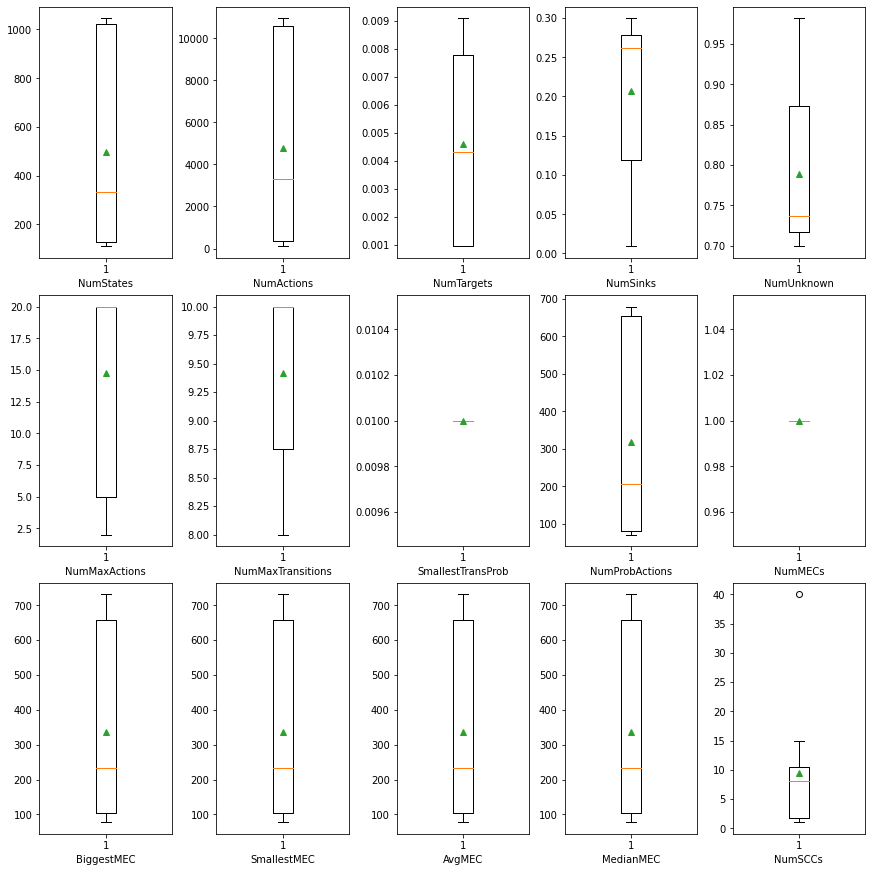

In [283]:
#Make Boxplots

entries_per_column = 5
entries_per_row = int(math.ceil(len(property_keys)/5))
fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
row = 0
column = 0
for property_key in property_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].boxplot(data[property_key], showmeans=True)
        axs[row, column].set_xlabel(property_key)
        column+=1

In [284]:
#Print out specific stuff you are interested in
data_as_np = dict(data)
for key in data_as_np.keys():
    data_as_np[key] = np.asarray(data_as_np[key])
    
#for key in property_keys:    
for key in ["NumStates", "BiggestMEC", "NumMECs", "NumMaxActions", "NumProbActions", "NumUnknown"]:
    print("Key: ", key)
    print("\t Min: ",data_as_np[key].min())
    print("\t Max: ",data_as_np[key].max())
    print("\t Mean: ",data_as_np[key].mean())

Key:  NumStates
	 Min:  110.0
	 Max:  1046.0
	 Mean:  495.0
Key:  BiggestMEC
	 Min:  77.0
	 Max:  731.0
	 Mean:  336.8333333333333
Key:  NumMECs
	 Min:  1.0
	 Max:  1.0
	 Mean:  1.0
Key:  NumMaxActions
	 Min:  2.0
	 Max:  20.0
	 Mean:  14.75
Key:  NumProbActions
	 Min:  71.0
	 Max:  679.0
	 Mean:  317.0
Key:  NumUnknown
	 Min:  0.69921875
	 Max:  0.9818181818181818
	 Mean:  0.788937760142708


## Look at some graph to gain understanding of dataset

In [285]:
x_axis = range(len(table_times))
y_axises = dict()

#Init y_axises
for key in config_keys:
    y_axises[key] = data[key]

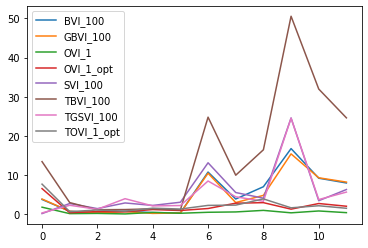

In [286]:
for config in y_axises.keys():
    plt.plot(x_axis, y_axises[config], label=config)
plt.legend()
plt.show()

### Interpret the graph

In [287]:
print(len(model_names))
print(len(data["NumStates"]))

12
12


In [288]:
#Get names of models above certain threshold

confs_to_compare = config_keys
#confs_to_compare = ["OVI_1", "OVI_100"]

fastest_solver = dict()
for index in range(len(data["NumStates"])):
    model = model_names[index]
    fastest_solver[model] = [10000000, []]
    for key in confs_to_compare:
        soln_time = data[key][index]
        if (soln_time != PENTALY_FOR_NOT_FINISHING):
            if (fastest_solver[model][0] > soln_time):
                fastest_solver[model] = [soln_time, [key]]
            elif (fastest_solver[model][0] == soln_time):
                fastest_solver[model][1].append(key)

In [290]:
bestSolvers = dict()
for config_key in confs_to_compare:
    bestSolvers[config_key] = 0

for index in range(len(data["NumStates"])):
    model_name = model_names[index]
    for config_key in fastest_solver[model_name][1]:
        bestSolvers[config_key]+=1

for config_key in confs_to_compare:
    print("Config %s was the best solution method %d / %d times" % (config_key, bestSolvers[config_key], len(table_times)))

Config BVI_100 was the best solution method 0 / 12 times
Config GBVI_100 was the best solution method 1 / 12 times
Config OVI_1 was the best solution method 10 / 12 times
Config OVI_1_opt was the best solution method 0 / 12 times
Config SVI_100 was the best solution method 1 / 12 times
Config TBVI_100 was the best solution method 0 / 12 times
Config TGSVI_100 was the best solution method 0 / 12 times
Config TOVI_1_opt was the best solution method 0 / 12 times


In [292]:
#If you want to know which Models a Conf won, use this:
check_conf = "TOVI_100"
explicit = True

for index in range(len(data["NumStates"])):
    model = model_names[index]
    if check_conf in fastest_solver[model][1]:
        print(model)
        if explicit:
            props = findModelWithNameInTable(table_properties, model)
            for prop in props:
                print(prop," : ", props[prop])

# Do classic Data Mining stuff

## Heatmaps

In [293]:
excluded_features = [
    #"NumTargets",
    #"SmallestTransProb"
]

correlation_dict = dict(data)

for feature in excluded_features:
    del correlation_dict[feature]

size = 10 + len(config_keys)
print(size)

18


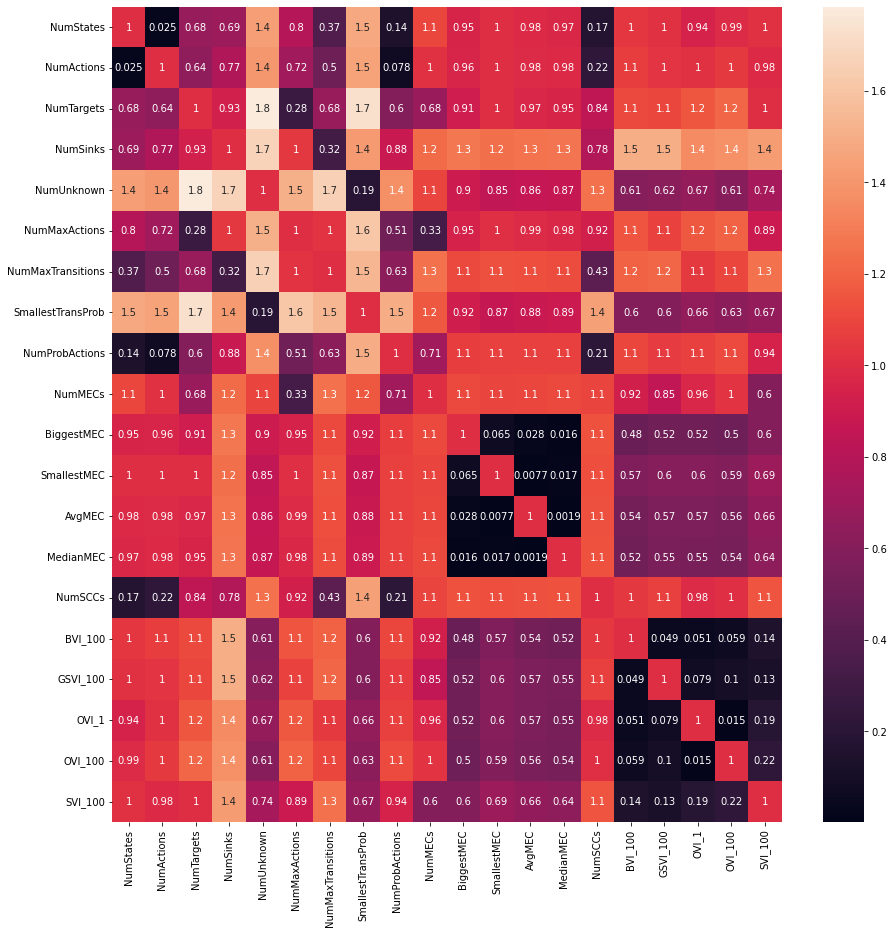

In [222]:
#Distance Correlation
fig = plt.figure(figsize=(size,size))
df = pd.DataFrame(correlation_dict,columns=correlation_dict.keys())

corrMatrix = df.corr(method=spatial.distance.correlation)
sn.heatmap(corrMatrix, annot=True)
plt.show()


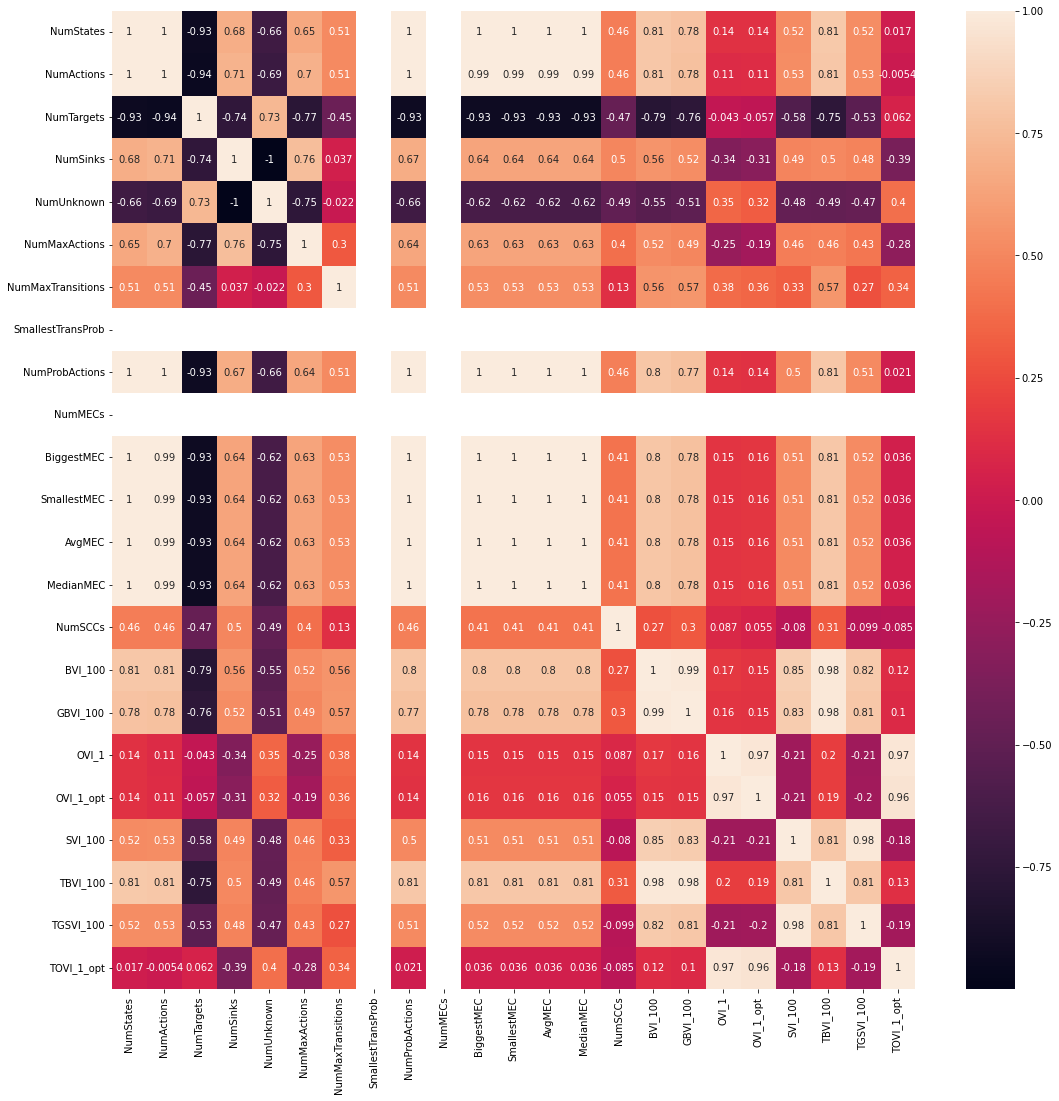

In [294]:
#Linear Correlation
fig = plt.figure(figsize=(size,size))

df = pd.DataFrame(correlation_dict,columns=correlation_dict.keys())

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


## Scatter Plots

In [295]:
#Scatterplot
def createScatterPlotForOneProperty(property_key):
    entries_per_column = int(math.sqrt(len(config_keys))+1)
    entries_per_row = entries_per_column
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(16,16))
    row = 0
    column = 0
    for key in config_keys:
        if (column == entries_per_column):
            row += 1
            column = 0
        axs[row, column].scatter(data[property_key], data[key])
        axs[row, column].set_xlabel(property_key),
        axs[row, column].set_ylabel(key)
        column+=1

def createScatterPlotForOneConfig(property_keys):
    entries_per_column = 1    
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            axs[row].scatter(data[property_key], data[key])
            axs[row].set_xlabel(property_key),
            axs[row].set_ylabel(key)
            column+=1

def createScatterPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            axs[row, column].scatter(data[property_key], data[key], alpha=0.2)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

def createHistPlotForMultipleProperties(property_keys):
    entries_per_column = len(config_keys)
    entries_per_row = len(property_keys)
    fix, axs = plt.subplots(entries_per_row, entries_per_column, figsize=(12,12), constrained_layout=True)
    row = 0
    column = 0
    for property_key in property_keys:
        for key in config_keys:
            if (column == entries_per_column):
                row += 1
                column = 0
            sn.histplot(x = data[property_key], y =  data[config_key], cbar=True)
            axs[row, column].set_xlabel(property_key),
            axs[row, column].set_ylabel(key)
            column+=1

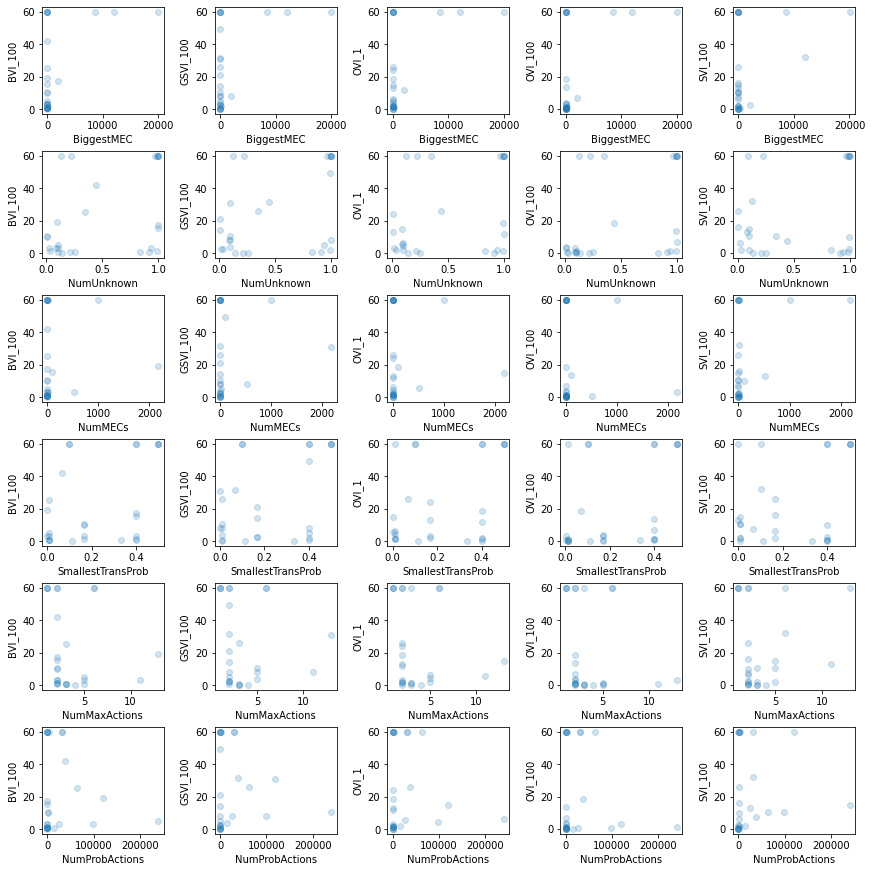

In [225]:
createScatterPlotForMultipleProperties(["BiggestMEC", "NumUnknown", "NumMECs", "SmallestTransProb", "NumMaxActions", "NumProbActions"])
#createScatterPlotForOneConfig(["BiggestMEC", "NumUnknown", "NumMECs", "NumStates", "SmallestTransProb"])

In [226]:
#createHistPlotForMultipleProperties(["BiggestMEC", "NumUnknown", "NumMECs", "NumStates", "NumMaxActions", "NumProbActions"])

## Chi-square Tests: Are two features independent?

In [128]:
def bin_estimate(length):
    return int(1+math.log2(length))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


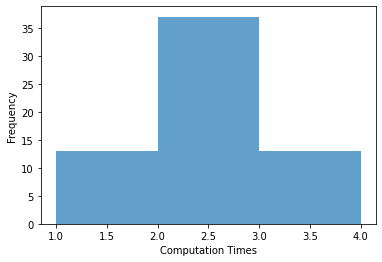

In [129]:
#Histograms
#Each Bin should contain at least (recommended) 13 entries
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
prop = "NumUnknown"

x_set = [1]*13 + [2]*37 + [3]*13
y_set = [100]*13 + [300]*37 + [500]*13
print(x_set)
x_bins = (1, 2, 3, 4)#bin_estimate(len(data_set))
y_bins = (100, 300, 500, 700)

x_hist_gram = np.histogram(x_set, bins=x_bins)
y_hist_gram = np.histogram(y_set, bins=(100, 200, 300))
n, bins, patches = plt.hist(x=x_set, bins=x_bins, alpha = 0.7)
plt.xlabel('Computation Times')
plt.ylabel('Frequency')

plt.show()


In [ ]:

H, xedges, yedges = np.histogram2d(x_set, y_set, bins=(x_bins, y_bins))
print(H)
# Histogram does not follow Cartesian convention (see Notes),

# therefore transpose H for visualization purposes.

H = H.T
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(131, title='imshow: square bins')

plt.imshow(H, interpolation='nearest', origin='lower')

In [ ]:
# create data
x = [0]*5000#np.random.normal(size=5000)
y = [1]*5000#np.random.normal(size=5000)
 
# Big bins
H, x_edges, y_edges, img = plt.hist2d(x, y, bins=(10,10), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# Small bins
#plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.jet)
#plt.show()
 
# If you do not set the same values for X and Y, the bins won't be a square!
#plt.hist2d(x, y, bins=(300, 30), cmap=plt.cm.jet)
#plt.show()

In [ ]:
#print(H)
ChiSq, p = stats.chisquare(np.ndarray.flatten(H))
print(ChiSq)
print(p)